## Demo: Early Stopping, Dropout

Neste notebook, um rede MLP é treinada com o conjunto [MNIST](https://). O propósito é ilustrar duas técnicas usadas durante o treinamento de redes neurais:
- *Early Stopping*
- *Dropout*.

![link text](https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png)

CREDITS: The example code in this section is adapted from https://github.com/Bjarten/early-stopping-pytorch/blob/master/MNIST_Early_Stopping_example.ipynb

In [8]:
# import libraries
import torch
import numpy as np
import matplotlib.pyplot as plt

In [9]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [10]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

def create_datasets(batch_size):

    # percentage of training set to use as validation
    valid_size = 0.2

    # convert data to torch.FloatTensor
    transform = transforms.ToTensor()

    # choose the training and test datasets
    train_data = datasets.MNIST(root='data', 
                                train=True,
                                download=True, 
                                transform=transform)

    test_data = datasets.MNIST(root='data',
                               train=False,
                               download=True,
                               transform=transform)

    # obtain training indices that will be used for validation
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = int(np.floor(valid_size * num_train))
    train_idx, valid_idx = indices[split:], indices[:split]
    
    # define samplers for obtaining training and validation batches
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)
    
    # load training data in batches
    train_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=train_sampler,
                                               num_workers=0)
    
    # load validation data in batches
    valid_loader = torch.utils.data.DataLoader(train_data,
                                               batch_size=batch_size,
                                               sampler=valid_sampler,
                                               num_workers=0)
    
    # load test data in batches
    test_loader = torch.utils.data.DataLoader(test_data,
                                              batch_size=batch_size,
                                              num_workers=0)
    
    return train_loader, test_loader, valid_loader

Now we build the NN, once again implemented as a subclass of `torch.nn.Module`.

We use a Multilayer Perceptron with 2 hidden layers.

- Input layer: 784 units (28 x 28)
- First hidden layer: 128 units (neurons)
- Second hidden layer: 128 units
- Output layer: 10 units

Both hidden layers use dropout to control overfitting, with dropout rate = 0.5. They also are configured with ReLU activation function.

The output layer

In [11]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 10)
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        # flatten image input
        x = x.view(-1, 28 * 28)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        # add hidden layer, with relu activation function
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        # add output layer
        x = self.fc3(x)
        return x

# initialize the NN
model = Net()
print(model)

Net(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=128, bias=True)
  (fc3): Linear(in_features=128, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


Next, we set the loss function and the optimizer. For the loss function, we use cross entropy, since we are building a predictive model for classification. For the optimizer, [Adam](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) is used.

In [12]:
# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizer = torch.optim.Adam(model.parameters())

The function bellow presents the code for training the NN.

Notice that **Early Stopping** regularization technique is used in the function bellow. Early stopping needs access to the validation loss to check if it has decreased or not. If it is the case the the loss has decreased, it will make a checkpoint of the current model. A checkpoint corresponds to saving the current model to disk.

Also, notice that the function bellow used minibatch training. This way, for training epoch, several batchs of examples are given to the NN, and the parameters are updated for each batch. The size of each minibatch is passed as an argument to the function.

In [13]:
def train_model(model, patience, n_epochs):
    
    # to track the training loss as the model trains
    train_losses = []
    # to track the validation loss as the model trains
    valid_losses = []
    # to track the average training loss per epoch as the model trains
    avg_train_losses = []
    # to track the average validation loss per epoch as the model trains
    avg_valid_losses = [] 
    
    # initialize the early_stopping object
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train() # prep model for training
        for batch, (data, target) in enumerate(train_loader, 1):
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # record training loss
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval() # prep model for evaluation
        for data, target in valid_loader:
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the loss
            loss = criterion(output, target)
            # record validation loss
            valid_losses.append(loss.item())

        # print training/validation statistics 
        # calculate average loss over an epoch
        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        valid_losses = []
        
        # early_stopping needs the validation loss to check if it has decresed, 
        # and if it has, it will make a checkpoint of the current model
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
        
    # load the last checkpoint with the best model
    model.load_state_dict(torch.load('checkpoint.pt'))

    return  model, avg_train_losses, avg_valid_losses

The next code cell sets three other hyperparameters: the amount of training epochs, the bacth size, and the patience (for Early Stopping). After that the loaders for train and validation sets are created, and the traininn process is executed.

In [14]:
n_epochs = 100
batch_size = 128

train_loader, test_loader, valid_loader = create_datasets(batch_size)

# early stopping patience; how long to wait after last time validation loss improved.
patience = 20

model, train_loss, valid_loss = train_model(model, patience, n_epochs)

[  1/100] train_loss: 0.69545 valid_loss: 0.25486
Validation loss decreased (inf --> 0.254856).  Saving model ...
[  2/100] train_loss: 0.32645 valid_loss: 0.19293
Validation loss decreased (0.254856 --> 0.192928).  Saving model ...
[  3/100] train_loss: 0.26259 valid_loss: 0.15728
Validation loss decreased (0.192928 --> 0.157276).  Saving model ...
[  4/100] train_loss: 0.22763 valid_loss: 0.13961
Validation loss decreased (0.157276 --> 0.139605).  Saving model ...
[  5/100] train_loss: 0.21533 valid_loss: 0.12818
Validation loss decreased (0.139605 --> 0.128175).  Saving model ...
[  6/100] train_loss: 0.19346 valid_loss: 0.12157
Validation loss decreased (0.128175 --> 0.121573).  Saving model ...
[  7/100] train_loss: 0.18153 valid_loss: 0.11698
Validation loss decreased (0.121573 --> 0.116980).  Saving model ...
[  8/100] train_loss: 0.17239 valid_loss: 0.10830
Validation loss decreased (0.116980 --> 0.108301).  Saving model ...
[  9/100] train_loss: 0.16050 valid_loss: 0.10657
Val

Since the train and validation losses were tracked during training, we can plot their values. This is done in the code cell bellow.

The generated plot presents two curves, one for the training losses, and another for the validation losses. A dotted red line is also presented. This line corresponds to the moment in which the best model (as measured on the validation set) is generated. Also notice that the training process continues after that moment for a few more epochs, duw to the value of the *patience* hyperparameter.

One thing that may seem strage at first is that the error on the train dataset if greated than the error on the validation set. However, this is an expected behaviour, since dropout is being used. For more details about this, see the discussion [here](stats.stackexchange.com/questions/187335/validation-error-less-than-training-error).

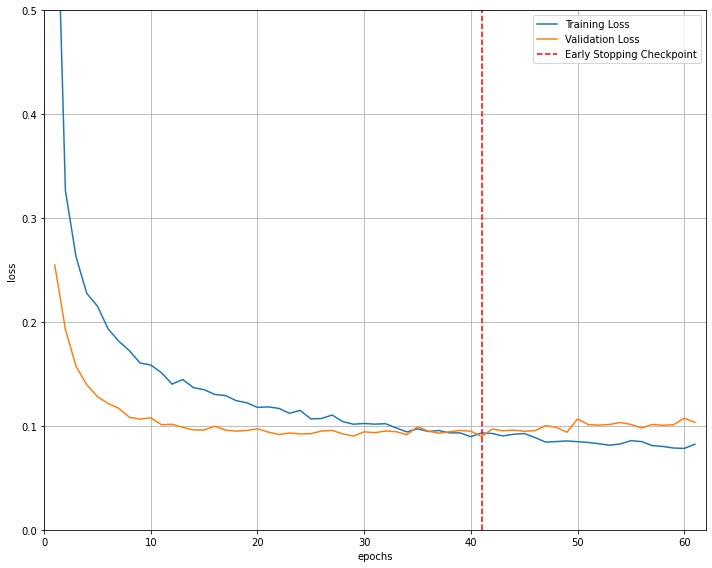

In [15]:
# visualize the loss as the network trained
fig = plt.figure(figsize=(10,8))
plt.plot(range(1,len(train_loss)+1),train_loss, label='Training Loss')
plt.plot(range(1,len(valid_loss)+1),valid_loss,label='Validation Loss')

# find position of lowest validation loss
minposs = valid_loss.index(min(valid_loss))+1 
plt.axvline(minposs, linestyle='--', color='r',label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.ylim(0, 0.5) # consistent scale
plt.xlim(0, len(train_loss)+1) # consistent scale
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

Now that the training process is finished, we can evaluate the generated model on the test set to get an estimate of its generalization perfomance.

In [16]:
# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    if len(target.data) != batch_size:
        break
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.081498

Test Accuracy of     0: 99% (970/979)
Test Accuracy of     1: 98% (1120/1133)
Test Accuracy of     2: 97% (1006/1030)
Test Accuracy of     3: 97% (987/1008)
Test Accuracy of     4: 96% (949/980)
Test Accuracy of     5: 97% (864/890)
Test Accuracy of     6: 97% (931/956)
Test Accuracy of     7: 97% (1006/1027)
Test Accuracy of     8: 96% (941/973)
Test Accuracy of     9: 96% (974/1008)

Test Accuracy (Overall): 97% (9748/9984)


As a sanity check, we can also print some of the example images in the test dataset, along with the predicted label for each one of them.

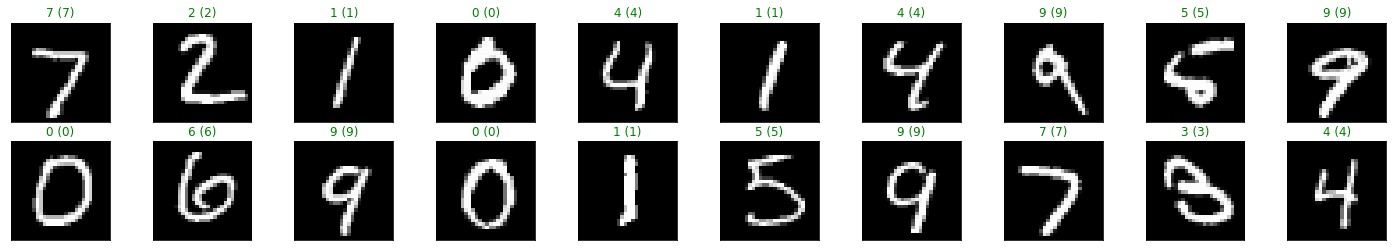

In [17]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()

# get sample outputs
output = model(images)
# convert output probabilities to predicted class
_, preds = torch.max(output, 1)
# prep images for display
images = images.numpy()

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(images[idx]), cmap='gray')
    ax.set_title("{} ({})".format(str(preds[idx].item()), str(labels[idx].item())),
                 color=("green" if preds[idx]==labels[idx] else "red"))